# Regression for concrete compressive strength

Notebook created by **Manuel David Soto** with a dataset from: 

https://archive-beta.ics.uci.edu/dataset/165/concrete+compressive+strength

The dataset was provided by I-Cheng Yeh, Department of Information Management, Chung-Hua University, Hsin Chu, Taiwan, who published the following article on this mater: 

    Yeh, I.-C. and Lien, L.-C. (2009) “Knowledge Discovery of Concrete Material Using Genetic Operation Trees,” Expert Systems With Applications, 36(3), pp. 5807–5812. doi: 10.1016/j.eswa.2008.07.004.

<br>

<img src="NB_images\ccs.jpg" style="width:450px" align="center">

<br>

Image from: https://www.concreteconstruction.net/how-to/materials/six-most-common-causes-of-low-cylinder-breaks_o

# Objective

The objective of this notebook is to generate a simple regression model capable to predict the compressive strength (MPa) of a concrete mixture (output or objective variable), from the eight input variables: the amount of seven components (kg/m3) and days of curing or age of the mixture.

# Data description

Here are the variable name, variable type, the measurement unit and a brief description. The order of this list corresponds to the order of the rows of the database:

| Name | Data Type | Measurement | Description |
| --- | --- | --- | --- |
| Cement (component 1)|quantitative|kg in a m3 mixture|Input Variable |
| Blast Furnace Slag (component 2)|quantitative|kg in a m3 mixture|Input Variable |
| Fly Ash (component 3)|quantitative |kg in a m3 mixture|Input Variable |
| Water  (component 4)|quantitative |kg in a m3 mixture|Input Variable |
| Superplasticizer (component 5)|quantitative|kg in a m3 mixture|Input Variable |
| Coarse Aggregate  (component 6)|quantitative|kg in a m3 mixture|Input Variable |
| Fine Aggregate (component 7)	|quantitative |kg in a m3 mixture|Input Variable |
| Age|quantitative |Day (1~365)|Input Variable |
| Concrete compressive strength|quantitative|MPa|Output Variable |

# Loading libraries

In [1]:
# Basic libraries

import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd

# EDA

from ydata_profiling import ProfileReport

# Data selection or transformation

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

# Algorithms

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Setting a seed for random processes

seed = 12345

# Loading data

In [3]:
# Data

df = pd.read_excel('Data\Concrete_Data_mod.xls')
df

Cement  BlastFurSlag  FlyAsh  Water  SuperPlasti  CourseAggre  \
0      540.0           0.0     0.0  162.0          2.5       1040.0   
1      540.0           0.0     0.0  162.0          2.5       1055.0   
2      332.5         142.5     0.0  228.0          0.0        932.0   
3      332.5         142.5     0.0  228.0          0.0        932.0   
4      198.6         132.4     0.0  192.0          0.0        978.4   
...      ...           ...     ...    ...          ...          ...   
1025   276.4         116.0    90.3  179.6          8.9        870.1   
1026   322.2           0.0   115.6  196.0         10.4        817.9   
1027   148.5         139.4   108.6  192.7          6.1        892.4   
1028   159.1         186.7     0.0  175.6         11.3        989.6   
1029   260.9         100.5    78.3  200.6          8.6        864.5   

      FineAggre  Age        CCS  
0         676.0   28  79.986111  
1         676.0   28  61.887366  
2         594.0  270  40.269535  
3         594.0  365  41.052780  
4         825.5  360  44.296075  
...         ...  ...        ...  
1025      768.3   28  44.284354  
1026      813.4   28  31.178794  
1027      780.0   28  23.696601  
1028      788.9   28  32.768036  
1029      761.5   28  32.401235  

[1030 rows x 9 columns]

# EDA

In general, it is a simple dataset, with only eight numeric variables, no null values, and few repeated rows. The Profiling Report allows to see strong positive correlations between CCS and Cement, SuperPlasti, and Age. On the contrary, strong negative correlations are observed between CCS and Water, and between Water and SuperPlasti.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cement        1030 non-null   float64
 1   BlastFurSlag  1030 non-null   float64
 2   FlyAsh        1030 non-null   float64
 3   Water         1030 non-null   float64
 4   SuperPlasti   1030 non-null   float64
 5   CourseAggre   1030 non-null   float64
 6   FineAggre     1030 non-null   float64
 7   Age           1030 non-null   int64  
 8   CCS           1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
df.describe()

Cement  BlastFurSlag       FlyAsh        Water  SuperPlasti  \
count  1030.000000   1030.000000  1030.000000  1030.000000  1030.000000   
mean    281.165631     73.895485    54.187136   181.566359     6.203112   
std     104.507142     86.279104    63.996469    21.355567     5.973492   
min     102.000000      0.000000     0.000000   121.750000     0.000000   
25%     192.375000      0.000000     0.000000   164.900000     0.000000   
50%     272.900000     22.000000     0.000000   185.000000     6.350000   
75%     350.000000    142.950000   118.270000   192.000000    10.160000   
max     540.000000    359.400000   200.100000   247.000000    32.200000   

       CourseAggre    FineAggre          Age          CCS  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918592   773.578883    45.662136    35.817836  
std      77.753818    80.175427    63.169912    16.705679  
min     801.000000   594.000000     1.000000     2.331808  
25%     932.000000   730.950000     7.000000    23.707115  
50%     968.000000   779.510000    28.000000    34.442774  
75%    1029.400000   824.000000    56.000000    46.136287  
max    1145.000000   992.600000   365.000000    82.599225

In [6]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data edition

In [7]:
# List of duplicated rows

print(len(df[df.duplicated()]), '\n')
df[df.duplicated()].sort_values('Cement')

25 



Cement  BlastFurSlag  FlyAsh  Water  SuperPlasti  CourseAggre  FineAggre  \
809   252.0           0.0     0.0  185.0          0.0       1111.0      784.0   
179   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
177   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
160   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
157   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
155   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
137   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
182   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
132   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
134   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
111   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
109   362.6         189.0     0.0  164.9         11.6        944.7      755.8   
91    362.6         189.0     0.0  164.9         11.6        944.7      755.8   
88    362.6         189.0     0.0  164.9         11.6        944.7      755.8   
86    362.6         189.0     0.0  164.9         11.6        944.7      755.8   
126   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
103   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
146   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
149   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
100   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
169   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
172   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
80    425.0         106.3     0.0  153.5         16.5        852.1      887.1   
123   425.0         106.3     0.0  153.5         16.5        852.1      887.1   
77    425.0         106.3     0.0  153.5         16.5        852.1      887.1   

     Age        CCS  
809   28  19.691435  
179   91  79.296635  
177   91  79.296635  
160   56  77.297154  
157   56  77.297154  
155   56  77.297154  
137   28  71.298713  
182   91  79.296635  
132   28  71.298713  
134   28  71.298713  
111    7  55.895819  
109    7  55.895819  
91     3  35.301171  
88     3  35.301171  
86     3  35.301171  
126   28  60.294676  
103    7  49.201007  
146   56  64.300532  
149   56  64.300532  
100    7  49.201007  
169   91  65.196851  
172   91  65.196851  
80     3  33.398217  
123   28  60.294676  
77     3  33.398217

In [8]:
# Drop of duplicated rows

df = df.drop_duplicates(keep='first')
df

Cement  BlastFurSlag  FlyAsh  Water  SuperPlasti  CourseAggre  \
0      540.0           0.0     0.0  162.0          2.5       1040.0   
1      540.0           0.0     0.0  162.0          2.5       1055.0   
2      332.5         142.5     0.0  228.0          0.0        932.0   
3      332.5         142.5     0.0  228.0          0.0        932.0   
4      198.6         132.4     0.0  192.0          0.0        978.4   
...      ...           ...     ...    ...          ...          ...   
1025   276.4         116.0    90.3  179.6          8.9        870.1   
1026   322.2           0.0   115.6  196.0         10.4        817.9   
1027   148.5         139.4   108.6  192.7          6.1        892.4   
1028   159.1         186.7     0.0  175.6         11.3        989.6   
1029   260.9         100.5    78.3  200.6          8.6        864.5   

      FineAggre  Age        CCS  
0         676.0   28  79.986111  
1         676.0   28  61.887366  
2         594.0  270  40.269535  
3         594.0  365  41.052780  
4         825.5  360  44.296075  
...         ...  ...        ...  
1025      768.3   28  44.284354  
1026      813.4   28  31.178794  
1027      780.0   28  23.696601  
1028      788.9   28  32.768036  
1029      761.5   28  32.401235  

[1005 rows x 9 columns]

In [9]:
df.head(80)

Cement  BlastFurSlag  FlyAsh  Water  SuperPlasti  CourseAggre  FineAggre  \
0    540.0           0.0     0.0  162.0          2.5       1040.0      676.0   
1    540.0           0.0     0.0  162.0          2.5       1055.0      676.0   
2    332.5         142.5     0.0  228.0          0.0        932.0      594.0   
3    332.5         142.5     0.0  228.0          0.0        932.0      594.0   
4    198.6         132.4     0.0  192.0          0.0        978.4      825.5   
..     ...           ...     ...    ...          ...          ...        ...   
75   475.0         118.8     0.0  181.1          8.9        852.1      781.5   
76   469.0         117.2     0.0  137.8         32.2        852.1      840.5   
78   388.6          97.1     0.0  157.9         12.1        852.1      925.7   
79   531.3           0.0     0.0  141.8         28.2        852.1      893.7   
81   318.8         212.5     0.0  155.7         14.3        852.1      880.4   

    Age        CCS  
0    28  79.986111  
1    28  61.887366  
2   270  40.269535  
3   365  41.052780  
4   360  44.296075  
..  ...        ...  
75    3  37.797074  
76    3  40.196451  
78    3  28.096147  
79    3  41.299612  
81    3  25.200348  

[80 rows x 9 columns]

# Multi regression models

Undoubtedly the DecisionTreeRegressor algorithm is the one that generates the best regression, with a score of almost one.

In [10]:
# Data partition

features = df.iloc[:, 0:8]
target = df.CCS

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

## Loop of models and metrics

In [11]:
# Regression models and scores

models = []

models.append(('LR', LinearRegression()))
models.append(('L', Lasso()))
models.append(('SVR', SVR()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor(random_state=seed)))
models.append(('RFR', RandomForestRegressor(random_state=seed)))

for name, model in models:
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    print(name, ':', score)

LR : 0.6169616053115083
L : 0.6167048483242061
SVR : 0.2137877249872192
KNR : 0.7903758029665067
DTR : 0.9969853078456884
RFR : 0.9831625265322084


In [12]:
# Regression models and other metrics

models = []

models.append(('LR', LinearRegression()))
models.append(('L', Lasso()))
models.append(('SVR', SVR()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor(random_state=seed)))
models.append(('RFR', RandomForestRegressor(random_state=seed)))

headers = ['Model', 'Score(R2)', 'MSE', 'RMSE', 'MAE', 'R2']
rows = []

for name, model in models:
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    
    y_pred = model.predict(X_train)
    
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, y_pred)
    rows.append([name, score, mse, rmse, mae])

print(tabulate(rows, headers=headers, tablefmt="fancy_outline"))

╒═════════╤═════════════╤════════════╤═══════════╤════════════╕
│ Model   │   Score(R2) │        MSE │      RMSE │        MAE │
╞═════════╪═════════════╪════════════╪═══════════╪════════════╡
│ LR      │    0.616962 │ 100.63     │ 10.0314   │  8.04722   │
│ L       │    0.616705 │ 100.697    │ 10.0348   │  8.04802   │
│ SVR     │    0.213788 │ 206.549    │ 14.3718   │ 11.5121    │
│ KNR     │    0.790376 │  55.0713   │  7.42101  │  5.61518   │
│ DTR     │    0.996985 │   0.792003 │  0.889946 │  0.0599638 │
│ RFR     │    0.983163 │   4.42345  │  2.1032   │  1.40577   │
╘═════════╧═════════════╧════════════╧═══════════╧════════════╛


# Improved linear regression (ILR)

Despite not having a good score, the LinearRegression algorithm is important because it is the one with the most explainability. After trying several transformations, it was not possible to improve the score of the LinearRegression algorithm. Despite this, it is important to explore its form (coefficients) since it is the algorithm that provides the most explainability.

In [13]:
# Pipeline with scaler

pipeline = Pipeline([
    ('feature_scaling', RobustScaler()),
    ('linear_regression', LinearRegression())
])

# Pipeline fit

ILR = pipeline.fit(X_train, y_train)

# Prediccions

ILR_predictions = ILR.predict(X_test)

# Score

score = ILR.score(X_train, y_train)
print("Score: ", score)

Score:  0.6169616053115083


## ILR equation

The value of the coefficients in the ILR equation gives a good idea of the importance of the input variables. We see that the Cement, BlastFurSlag, FlyAsh, and Age variables are the ones with higher coefficients so they contribute the most to the increase in concrete strength, while the Water is the only variable that has a negative coefficient therefor a negative contribution to the concrete strength.

In [14]:
# Coefficients of the ILR

ILRE = pipeline.named_steps['linear_regression']

b0 = ILRE.intercept_
print('bo:', b0, '\n')

coefficients = ILRE.coef_
print('coefficients:', coefficients)

bo: 20.170490509528136 

coefficients: [17.14072496 13.29129006 10.09438651 -4.82931441  3.26269941  1.2234267
  0.59424486  5.84957716]


In [15]:
# Equation

equation = f"y = {b0:.2f}"
for i, coef in enumerate(coefficients):
    equation += f" + {coef:.2f} * x{i+1}"
print("ILR equation:")
print(equation)

ILR equation:
y = 20.17 + 17.14 * x1 + 13.29 * x2 + 10.09 * x3 + -4.83 * x4 + 3.26 * x5 + 1.22 * x6 + 0.59 * x7 + 5.85 * x8


## Importance of the variables in the ILR

In [16]:
%matplotlib inline

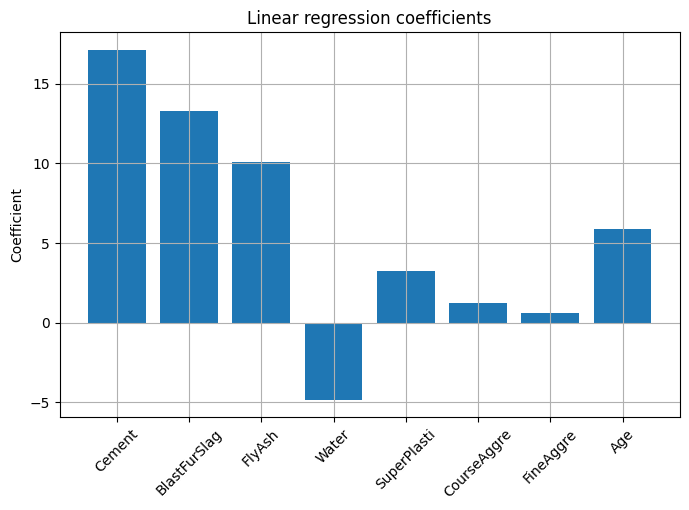

In [17]:
plt.figure(figsize=(8,5))
plt.bar(features.columns, coefficients)
plt.xticks(rotation=45)
plt.title('Linear regression coefficients')
plt.ylabel('Coefficient')
plt.grid();

## ILR and residual

Both plots, the actual CCS versus the predicted, and the residual, show a decrease in dispersion beyond 40 MPa on CCS. The pattern in the resudual plot is far from the ideal (random distribution around zero), rather it presents a bias and heteroscedastic behavior (coning upwards) which speaks of the low quality of the ILR.

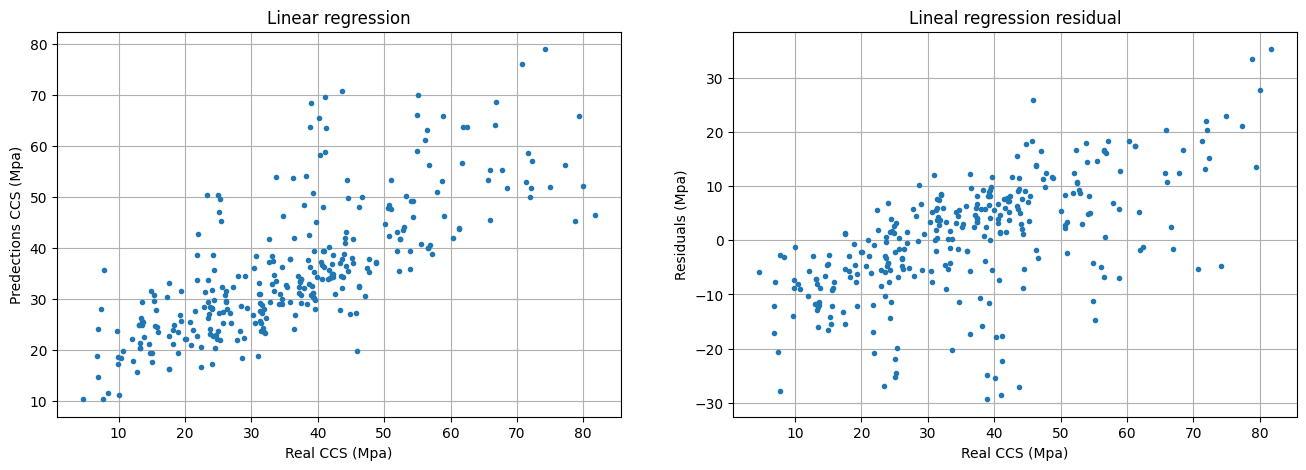

In [18]:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot(y_test, ILR_predictions, '.');
plt.xlabel('Real CCS (Mpa)')
plt.ylabel('Predections CCS (Mpa)')
plt.title('Linear regression')
plt.grid()

plt.subplot(122)
plt.plot(y_test, y_test - ILR_predictions, '.');
plt.xlabel('Real CCS (Mpa)')
plt.ylabel('Residuals (Mpa)')
plt.title('Lineal regression residual')
plt.grid();

# Decision tree regression (DTR)

For this dataset, the DTR is the best regression algorithm. To reduce its complexity and make it more representable (a tree with less levels), it was decided to establish a maximum depth of 10, reduction which also slightly reduces the score. A reduction of depth beyond this value start to introduce artifacts that are evidents in the final plots.

In [19]:
DTR = DecisionTreeRegressor(random_state=seed, max_depth=10)
DTR = DTR.fit(X_train, y_train)

In [20]:
DTR.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12345,
 'splitter': 'best'}

In [21]:
DTR.score(X_train, y_train)

0.9831023325013267

## DTR representation

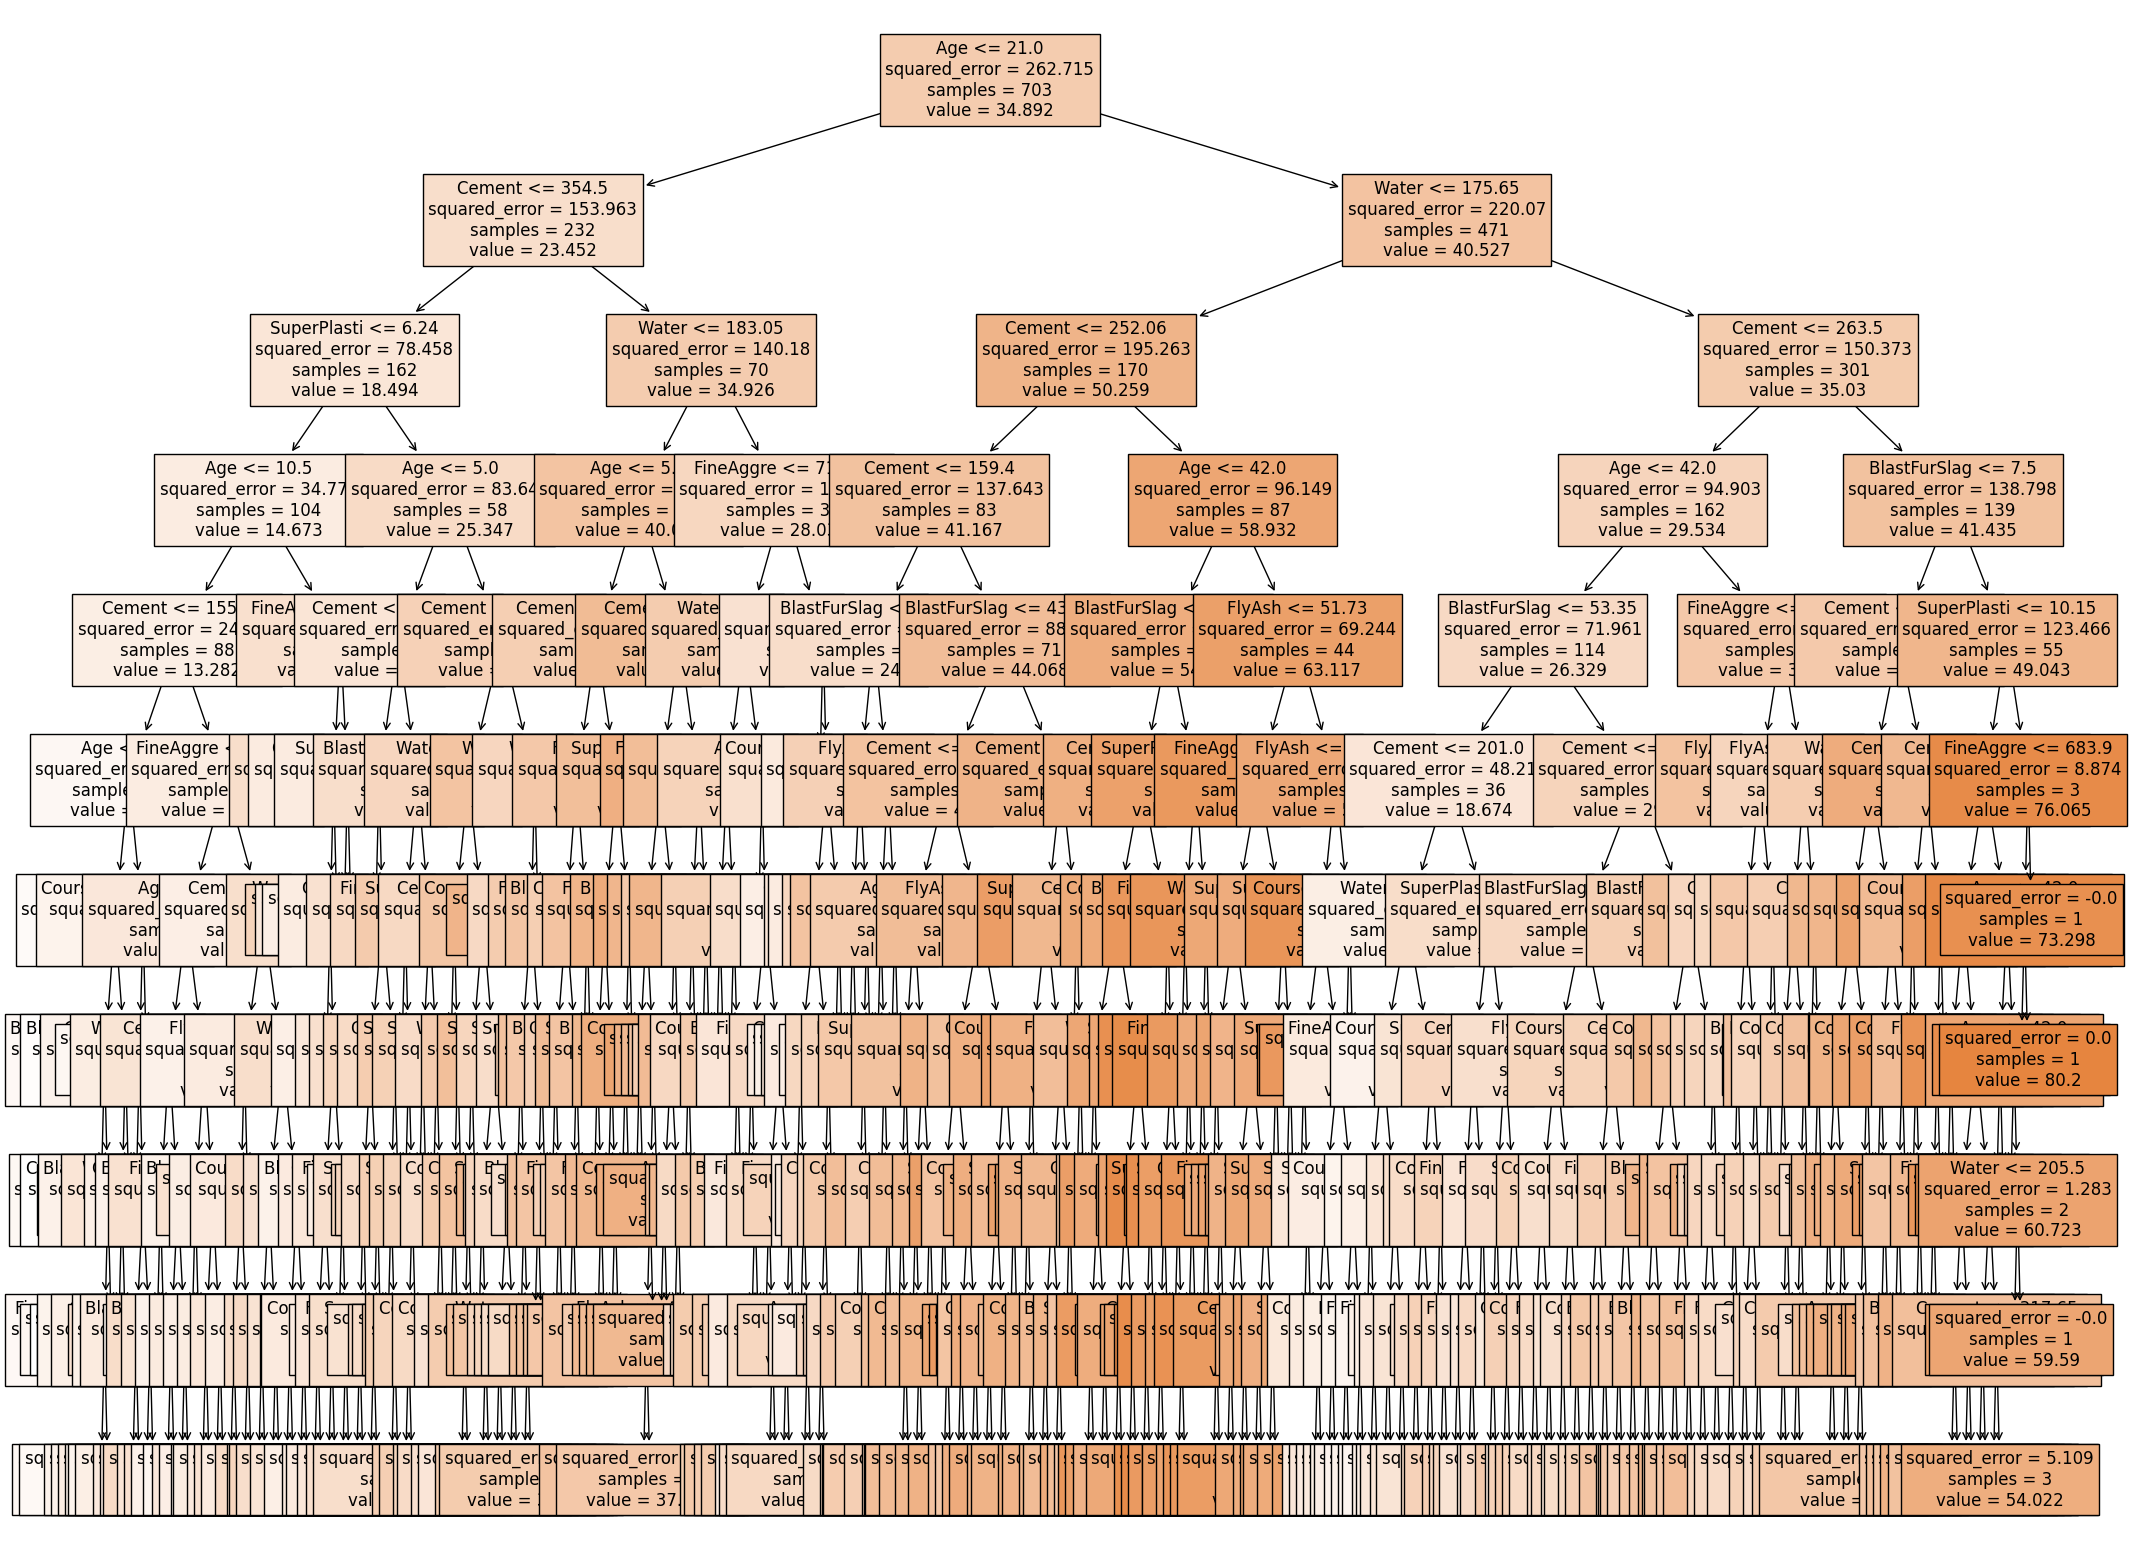

In [22]:
plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTR, 
                   feature_names=df.iloc[:, 0:8].columns,  
                   class_names={0:'Malignant', 1:'Benign'},
                   filled=True,
                  fontsize=12)

## DTR variable importances

Unlike the ILR coefficients, where the water coefficient is negative, the variable importaces in the DTR algorithm are all positive. The order in this case is also different, with Cement, Age, and SuperPlasti been the top three.

In [23]:
importances = DTR.feature_importances_
importances

array([0.30921983, 0.06954677, 0.02170645, 0.17470078, 0.04873583,
       0.01612928, 0.03203726, 0.3279238 ])

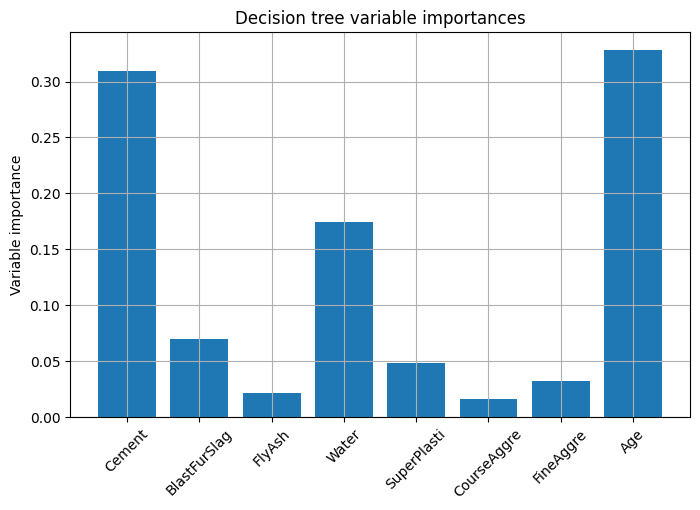

In [24]:
plt.figure(figsize=(8,5))
plt.bar(features.columns, importances)
plt.xticks(rotation=45)
plt.title('Decision tree variable importances')
plt.ylabel('Variable importance')
plt.grid();

## DTR and residual

Both plots, the actual CCS vs. the predicted, and the residual, show ideal patterns. In the first the point show an excellent one to one pattern, in the second plot the points are random distribution around zero without an obvious pattern. However the summe of the residual is far from been zero.

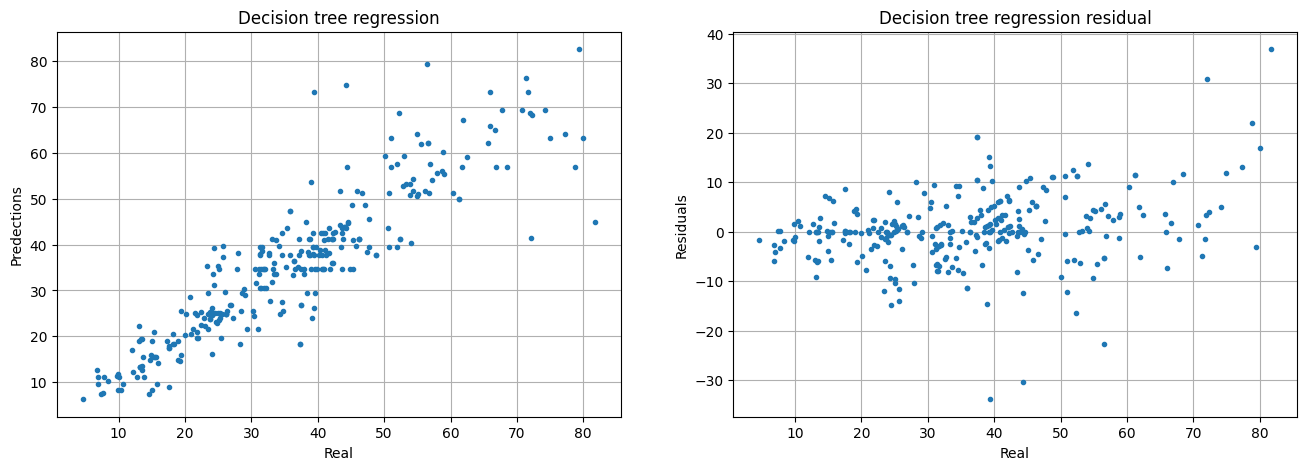

In [25]:
DTR_predictions = DTR.predict(X_test)

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot(y_test, DTR_predictions, '.');
plt.xlabel('Real')
plt.ylabel('Predections')
plt.title('Decision tree regression')
plt.grid()

plt.subplot(122)
plt.plot(y_test, y_test - DTR_predictions, '.');
plt.xlabel('Real')
plt.ylabel('Residuals')
plt.title('Decision tree regression residual')
plt.grid();

In [26]:
# Summe of rediduals

sum(y_test - DTR_predictions)

146.3921176456786

# Conclusions

The Decision tree regression is the best of all the algorithms tested, with a score close to one, but due to its nature, with little explicability. On the opposite side we have the linear regression algorithm with low score but high explicability and an understandable equation. The following table summarizes the results of this notebook:

| Model | Main variables in decreasing order | Score | Explicability |
| --- | --- | --- | --- |
| ILR | Cement, BlastFurSlag, FlyAsh, Age | 0.615| High |
| DTR| Age, Cement, Water(-), FineAgre |0.983| Low |
